# Example: Linear Map with Uniform Sampling
([From BET Documentation](http://ut-chg.github.io/BET/examples/example_rst_files/linearMapUniformSampling.html#linearmap))


We will walk through the following [example](linearMapUniformSampling.py). This example solves a stochastic inverse problem for a linear 3-to-2 map. We refer to the map as the QoI map, or just a QoI. We refer to the range of the QoI map as the data space. The 3-D input space is discretized with i.i.d. uniform random samples or a regular grid of samples. We refer to the input space as the parameter space, and use parameter to refer to a particular point (e.g., a particular random sample) in this space. A reference parameter is used to define a reference QoI datum and a uniform probability measure is defined on a small box centered at this datum. The measure on the data space is discretized either randomly or deterministically, and this discretized measure is then inverted by BET to determine a probability measure on the parameter space whose support contains the measurable sets of probable parameters. We often use emulation to estimate the measures of sets when random sampling is used. 1D and 2D marginals are calculated, smoothed, and plotted.

The actual process is quite simple requiring a total of 5 steps to solve the stochastic inverse problem with BET excluding any post-processing the user may want. In general the user will probably not write code with various options as was done here for pedagogical purposes. We break down the actual example included with BET step-by-step below, but first, to showcase the overall simplicitly, we show the “entire” code (omitting setting the environment, post-processing, and commenting) required for solving the stochastic inverse problem using some default options:

## Step (0): Setting up the Environment
Import the necessary modules:

In [1]:
import numpy as np
import bet.calculateP.simpleFunP as simpleFunP
import bet.calculateP.calculateP as calculateP
import bet.postProcess.plotP as plotP
import bet.postProcess.plotDomains as plotD
import bet.sample as samp
import bet.sampling.basicSampling as bsam

## Step (1): Define interface to the model

Import the Python script interface to the (simple Python) [model](myModel.py) that takes as input a numpy array of model input parameter samples, generated from the sampler (see below), evaluates the model to generate QoI samples, and returns the QoI samples:

In [2]:
from myModel import my_model

Define the sampler that will be used to create the discretization object, which is the fundamental object used by BET to compute solutions to the stochastic inverse problem. The sampler and my_model is the interface of BET to the model, and it allows BET to create input/output samples of the model:

In [4]:
sampler = bsam.sampler(my_model)

## Step (2): Describe and sample the input space
Initialize the (3-dimensional) input parameter sample set object and set the parameter domain to be a unit-cube:

In [5]:
input_samples = samp.sample_set(3)
input_samples.set_domain(np.repeat([[0.0, 1.0]], 3, axis=0))

### (a) Suggested Changes for User Exploration:
Try with and without random sampling.

If using random sampling, try num_samples = 1E3 and num_samples = 1E4. See what happens when num_samples = 1E2. Try using 'lhs' instead of 'random' in the random_sample_set.

If using regular sampling, try different numbers of samples per dimension:


In [7]:
randomSampling = False
if randomSampling is True:
    input_samples = sampler.random_sample_set('random', input_samples, num_samples=1E3)
else:
    input_samples = sampler.regular_sample_set(input_samples, num_samples_per_dim=[15, 15, 10])

### (b) Suggested Changes for User Exploration:

A standard Monte Carlo (MC) assumption is that every Voronoi cell has the same volume. If a regular grid of samples was used, then the standard MC assumption is true.

See what happens if the MC assumption is not assumed to be true, and if different numbers of points are used to estimate the volumes of the Voronoi cells:

In [8]:
MC_assumption = True
if MC_assumption is False:
    input_samples.estimate_volume(n_mc_points=1E5)
else:
    input_samples.estimate_volume_mc()

## Step (3): Generate QoI samples
Create the discretization object holding all the input (parameter) samples and output (QoI) samples using the sampler:

In [19]:
my_discretization = sampler.compute_QoI_and_create_discretization(input_samples,
                                               savefile = '3to2_discretization.txt.gz')

At this point, all of the model information has been extracted for BET (with the possibly exception of evaluating the model to generate a reference QoI datum or a distribution of the QoI), so the model is no longer required for evaluation. The user could do Steps (0)-(3) in a separate script, and then simply load the discretization object as part of a separate BET script that does the remaining steps. When the model is expensive to evaluate, this is an attractive option since we can now solve the stochastic inverse problem (with many different distributions defined on the data space) without ever having to re-solve the model (so long as we are happy with the resolution provided by the current discretization of the parameter and data spaces).

## Step (4): Describe the data distribution
This problem is nominally a “parameter identification under uncertainty” problem. Thus, we take a reference QoI datum (from one more model solve), and define a distribution “around” this datum.

### (c) Suggested Changes for User Exploration:
Try different reference parameters that produce different reference QoI data.:

In [35]:
param_ref = np.array([0.5, 0.5, 0.5])
#param_ref = np.array([0.75, 0.75, 0.5])
#param_ref = np.array([0.75, 0.75, 0.75])
#param_ref = np.array([0.5, 0.5, 0.75])

Q_ref =  my_model(param_ref)

Use the reference samples and discretization to generate plots (this is completely optional):

In [36]:
plotD.scatter_2D_multi(input_samples, ref_sample= param_ref, showdim = 'all',
                       filename = 'linearMap_ParameterSamples',
                       file_extension = '.svg')
plotD.show_data_domain_2D(my_discretization, Q_ref = Q_ref, file_extension='.svg')

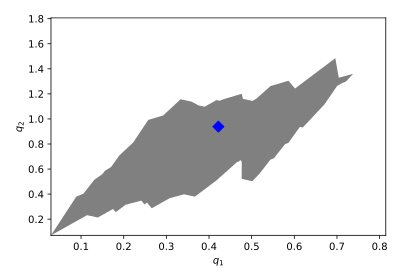

In [37]:
from IPython.display import SVG
SVG("q1_q2_domain_Q_cs.svg")


Further figures can be found in the generated figure file folder, [figs/](figs/).

### (d) Suggested Changes for User Exploration:

Try different ways of discretizing the probability measure on the data space defined as a uniform probability measure on a rectangle centered at Q_ref whose size is determined by scaling the circumscribing box of the data space:

In [38]:
randomDataDiscretization = False
if randomDataDiscretization is False:
    simpleFunP.regular_partition_uniform_distribution_rectangle_scaled(
        data_set=my_discretization, Q_ref=Q_ref, rect_scale=0.25,
        cells_per_dimension = 3)
else:
    simpleFunP.uniform_partition_uniform_distribution_rectangle_scaled(
        data_set=my_discretization, Q_ref=Q_ref, rect_scale=0.25,
        M=50, num_d_emulate=1E5)

## Step (5): Solve the stochastic inverse problem

Calculate probablities on the parameter space (which are stored within the discretization object):

In [39]:
calculateP.prob(my_discretization)

## Step (6) [Optional]: Post-processing

There are ways to determine “optimal” smoothing parameters (e.g., see CV, GCV, and other similar methods), but we have not incorporated these into the code as lower-dimensional marginal plots generally have limited value in understanding the structure of a high dimensional non-parametric probability measure.

The user may want to change nbins or sigma in the plotP.* inputs (which influences the kernel density estimation with smaller values of sigma implying a density estimate that looks more like a histogram and larger values smoothing out the values more).

In general, the user will have to tune these for any given problem especially when looking at marginals of higher-dimensional problems with parameter ranges that have disparate scales (assuming the parameters were not first normalized as part of a “un-dimensionalization” of the space, which is highly encouraged):

In [40]:
(bins, marginals2D) = plotP.calculate_2D_marginal_probs(input_samples,
                                                        nbins = [10, 10, 10])

marginals2D = plotP.smooth_marginals_2D(marginals2D, bins, sigma=0.2)

plotP.plot_2D_marginal_probs(marginals2D, bins, input_samples, filename = "linearMap",
                             lam_ref=param_ref, file_extension = ".svg", plot_surface=False)

(bins, marginals1D) = plotP.calculate_1D_marginal_probs(input_samples,
                                                        nbins = [10, 10, 10])
marginals1D = plotP.smooth_marginals_1D(marginals1D, bins, sigma=0.2)

plotP.plot_1D_marginal_probs(marginals1D, bins, input_samples, filename = "linearMap",
                             lam_ref=param_ref, file_extension = ".svg")

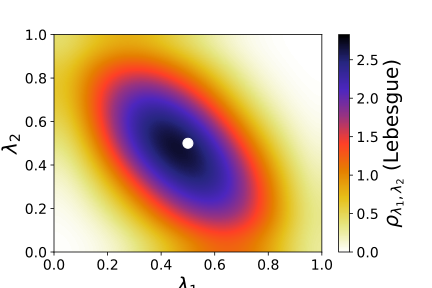

In [44]:
from IPython.display import SVG
SVG("linearMap_2D_0_1.svg")

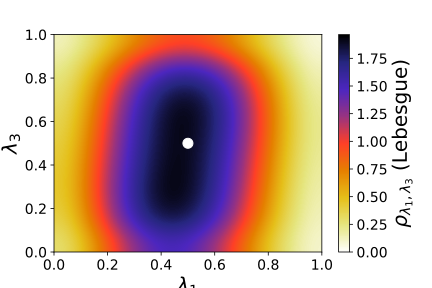

In [42]:
from IPython.display import SVG
SVG("linearMap_2D_0_2.svg")

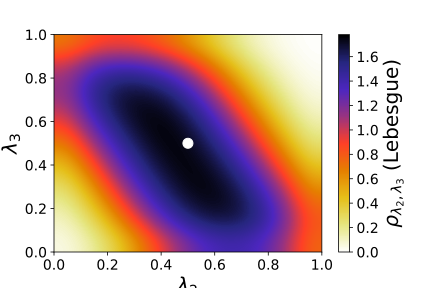

In [46]:
from IPython.display import SVG
SVG("linearMap_2D_1_2.svg")